In [3]:
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import time
%matplotlib inline

In [4]:
start_date = dt.datetime(1962,1,1)
end_date = dt.datetime.today()

### FRED Data Identifiers

1) 6-Mo Const. Maturity Rate: DGS6MO<br/>
2) 1-Year Const. Maturity Rate: DGS1 <br/>
3) 2-Year Const. Maturity Rate: DGS2<br/>
4) 3-Year Const. Maturity Rate: DGS3<br/>
5) 5-Year Const. Maturity Rate: DGS5<br/>
6) 7-Year Const. Maturity Rate: DGS7<br/>
7) 10-Year Const. Maturity Rate: DGS10<br/>
8) 20-Year Const. Maturity Rate: DGS20<br/>
9) 30-Year Const. Matuirty Rate: DGS30<br/>
10) Consumer Price Index for All Urban Consumers: All Items: CPIAUCSL<br/>
11) Consumer Price Index for All Urban Consumers: All Items Less Food and Energy: CPILFESL<br/>
12) Personal Consumption Expenditures: Chain-type Price Index: PCEPI<br/>
13) Personal Consumption Expenditures Excluding Food and Energy (Chain-Type Price Index): PCEPILFE

In [5]:
###Download Data for Historical Treasury yields

# First, store FRED IDs in a dictionary key = maturity (in years), value = yield
ids_const_maturity_rate = {.5: 'DGS6MO'}
for i in [1,3,5,7,10,20,30]:
    ids_const_maturity_rate[i] = 'DGS' + str(i) 
    
# Get Data from FRED API including all NANs
raw_yields = data.DataReader(ids_const_maturity_rate.values(), 'fred', start_date, end_date)

In [6]:
### Get Price Index Data
ids_price_indices = {'cpi': 'CPIAUCSL',
                    'cpi_core': 'CPILFESL',
                    'pce': 'PCEPI',
                    'pce_core': 'PCEPILFE'}
consumer_price_indices = data.DataReader(ids_price_indices.values(), 'fred', start_date, end_date)


In [7]:
### Calculate Inflation Rates 
inflation_yoy = consumer_price_indices.pct_change(12)

In [8]:
   
### Get Stock Index Data
stock_prices = data.DataReader('^GSPC', 'yahoo', dt.datetime(1970,1,1), end_date)

In [9]:
def resample_and_calculate_returns(df, resamp_freq = 'BM', pct_chg = True):
    """Resample DataFrame by given frequency and calculate the one-period return
    df: DataFrame
        DataFrame of Yields or Stock Prices
    resamp_freq: string
        Frequency to resample the data. ('B','W-FRI', BM', )
        B = Business Day, W-FRI = Week Ending Friday, BM = Business Month
    pct_chg: bool
        If True, calculate percent change, else calculate arithmetic difference.
    """
    resampled = df.resample(resamp_freq).last()
    if pct_chg:
        return resampled.pct_change(1)[1:]
    else:
        return resampled.diff(1)[1:]

In [10]:
yield_changes_monthly = resample_and_calculate_returns(raw_yields, pct_chg=False).resample('M').last()
stock_returns_monthly = resample_and_calculate_returns(stock_prices, pct_chg = True).Close.resample('M').last()

## Inflation and 60-Month Rolling Correlation Chart (stocks vs yields)

In [11]:
# Change Index dates from month start to month end (for axis alignment)
inflation_yoy = inflation_yoy.resample('M').last()
inflation_yoy.dropna().head()

,CPILFESL,CPIAUCSL,PCEPILFE,PCEPI
DATE,,,,
1963-01-31,0.009615,0.013316,0.013076,0.013864
1963-02-28,0.012821,0.012288,0.012459,0.012091
1963-03-31,0.012780,0.011269,0.010646,0.009951
1963-04-30,0.012780,0.008937,0.011671,0.008712
1963-05-31,0.009554,0.008929,0.011979,0.009655


In [12]:
#Calculate rolling correlation
rolling_correlation = stock_returns_monthly.rolling(60,60).corr( yield_changes_monthly.DGS10).dropna()
rolling_correlation.head()

1975-01-31   -0.280496
1975-02-28   -0.252073
1975-03-31   -0.230765
1975-04-30   -0.145571
1975-05-31   -0.149837
Freq: M, dtype: float64

## Plots

#### Plot Inflation Metrics on Main Plot

#### Plot Correlation of Stocks vs. Yields on Subplot

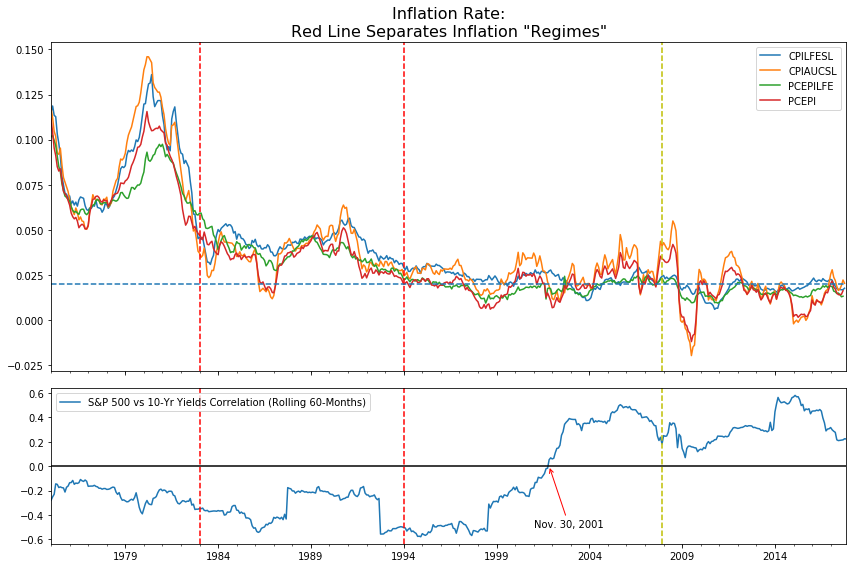

In [13]:
#Calculate rolling correlation
rolling_correlation = stock_returns_monthly.rolling(60,60).corr( yield_changes_monthly.DGS10).dropna()

# Setup the figure and axes
fig = plt.figure(figsize = (12,8))
ax1 = plt.subplot2grid((3,1), (0,0), rowspan = 2)

# Align the indices of the inflation and correlation dataframes
# inflation_df, corr_df = inflation_yoy.align(rolling_correlation, axis=0)

# Plot the Inflation Data
inflation_yoy.plot(ax = ax1)
ax1.set_title('Inflation Rate:\nRed Line Separates Inflation "Regimes"', fontsize = 16);

# Draw a 2% Reference Line
ax1.axhline(.02, linestyle = '--')

# Plot the Correlation Data
ax2 = plt.subplot2grid((3,1), (2,0), sharex=ax1)
rolling_correlation.plot(ax = ax2, label = 'S&P 500 vs 10-Yr Yields Correlation (Rolling 60-Months)');
ax2.axhline(0, color = 'k')
ax2.legend(loc = 'best');

# Input Vertical Lines to Separate Inflation Regimes
for ax in (ax1, ax2):
    ax.axvline(dt.datetime(1983,1,1), linestyle = '--',color = 'r')
    ax.axvline(dt.datetime(1994,1,1), linestyle = '--',color = 'r')
    ax.axvline(dt.datetime(2007,12,31), linestyle = '--',color = 'y')
    
# Annotations
ax2.annotate("Nov. 30, 2001",(dt.datetime(2001, 11, 30), 0), ( dt.datetime(2001, 01,1), -.5),
            arrowprops = {'arrowstyle': '->', 'color':'r'});

plt.tight_layout()

### Analysis by Inflation Regime

#### Let's first create a series that contains the inflation regime label

In [14]:
inflation_regime_dict = {1: dt.datetime(1983,1,1), 
                         2: dt.datetime(1994,1,1),
                         3: dt.datetime(2007,12,31)}
    

In [15]:
def get_inflation_regime(column_index):
    value = column_index
    if value < inflation_regime_dict[1]:
        return "1962 - 1983"
    elif value < inflation_regime_dict[2]:
        return "1983 - 1994"
    elif value < inflation_regime_dict[3]:
        return '1994 - 2007'
    else:
        return '2008 - 2017'

In [16]:
inflation_regime_id = \
    pd.Series(stock_returns_monthly.index, 
              index = stock_returns_monthly.index)\
    .apply(get_inflation_regime)

In [20]:
# Combine all data into one dataframe
df = pd.concat([inflation_regime_id, 
                stock_returns_monthly, 
                yield_changes_monthly.DGS10],
               axis = 1).dropna()
df.columns = ['Inflation Regime', 'Monthly Stock Returns', 'Monthly Change in 10-Yr Yields']
df.head()

,Inflation Regime,Monthly Stock Returns,Monthly Change in 10-Yr Yields
DATE,,,
1970-02-28,1962 - 1983,0.052694,-0.85
1970-03-31,1962 - 1983,0.001452,0.18
1970-04-30,1962 - 1983,-0.090483,0.74
1970-05-31,1962 - 1983,-0.060967,0.13
1970-06-30,1962 - 1983,-0.050033,-0.27


#### Correlation Analysis Grouped by Regime

In [33]:
# Calculate Correlation of Monthly Stock Returns
# with Yield Changes grouped by inflation regime
df.groupby("Inflation Regime").corr()\
    .xs('Monthly Change in 10-Yr Yields', level = 1 )[['Monthly Stock Returns']]

,Monthly Stock Returns
Inflation Regime,
1962 - 1983,-0.298246
1983 - 1994,-0.303835
1994 - 2007,0.093166
2008 - 2017,0.299771


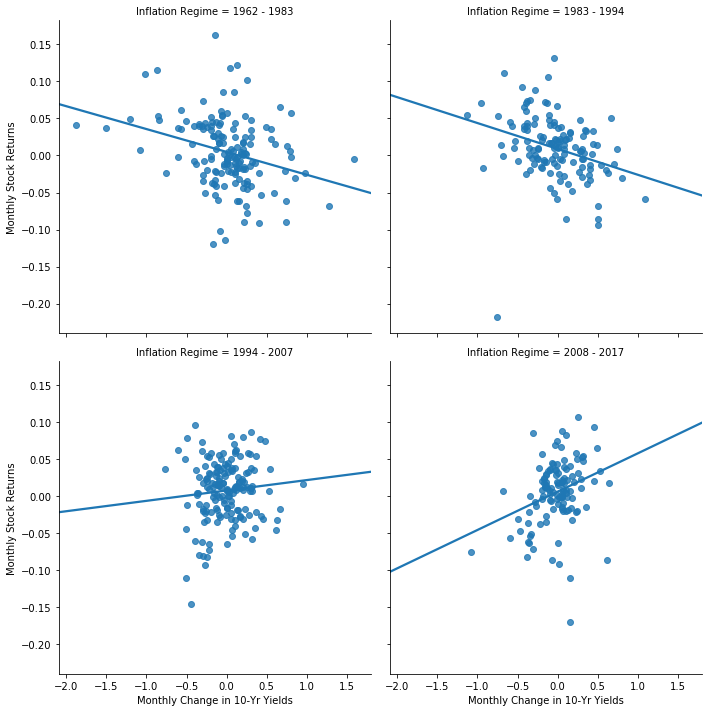

In [34]:
# Plot Scatter Plots by Inflation Regime with regression line
g = sns.lmplot(data = df, x = 'Monthly Change in 10-Yr Yields', y = 'Monthly Stock Returns',
               col = 'Inflation Regime', col_wrap = 2, ci=0)

#### Descriptive Stats and Histograms

In [38]:
grouped = df.groupby('Inflation Regime')
# info = grouped.describe()['Monthly Stock Returns']
info = grouped['Monthly Stock Returns'].agg(['count', 'mean', 'std', 'skew', pd.Series.kurtosis, 
                                      'min','median', 'max'])

info

,count,mean,std,skew,kurt,min,median,max
Inflation Regime,,,,,,,,
1962 - 1983,155,0.004310,0.046290,0.199987,0.899984,-0.119335,0.000203,0.163047
1983 - 1994,132,0.010087,0.043529,-0.927382,5.342660,-0.217630,0.010133,0.131767
1994 - 2007,167,0.007761,0.040359,-0.602045,0.869328,-0.145797,0.012156,0.096720
2008 - 2017,120,0.005590,0.043509,-0.782349,1.895856,-0.169425,0.009791,0.107723


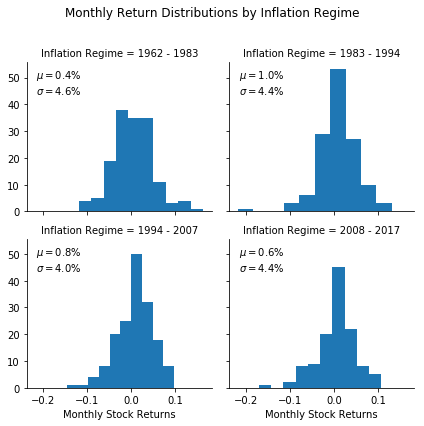

In [31]:
# Create a Histogram of Monthly Returns for each inflation Regime
g = sns.FacetGrid(data=df, col='Inflation Regime', col_wrap=2)
g.map(plt.hist, 'Monthly Stock Returns'  );

# Annotate Each axes in the grid with the mean and standard deviation
for ax, regime in zip(g.axes, info.index):
    mean_text = '$\mu={:.1f}$%'.format(info.loc[regime, 'mean']*100)
    std_text = '$\sigma={:.1f}$%'.format(info.loc[regime, 'std']*100)
    ax.annotate(mean_text + '\n' + std_text,
                xy=(0.05,0.8), 
                xycoords='axes fraction', 
                backgroundcolor='white')
    
g.fig.suptitle("Monthly Return Distributions by Inflation Regime")
g.fig.subplots_adjust(top=0.85)

### Productivity Growth By Year

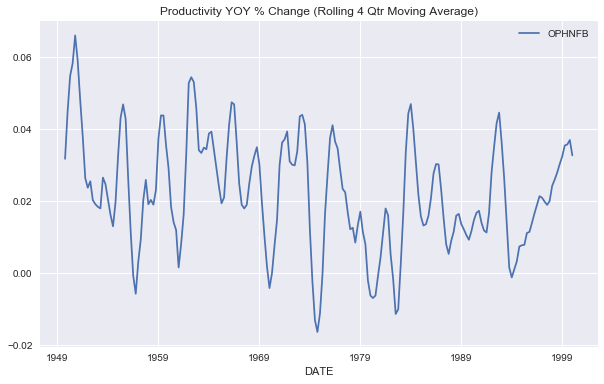

In [35]:
# %load Productivity.py
prod_df = data.DataReader("OPHNFB", 'fred', '1948', '2000')
prod_pct_df = prod_df.pct_change(4)[4:]

ma_len = 4
prod_pct_ma = prod_pct_df.rolling(ma_len).mean()

fig, ax = plt.subplots(figsize = (10,6))

prod_pct_ma.plot(ax = ax)
ax.set_title('Productivity YOY % Change (Rolling 4 Qtr Moving Average)')
plt.show()
